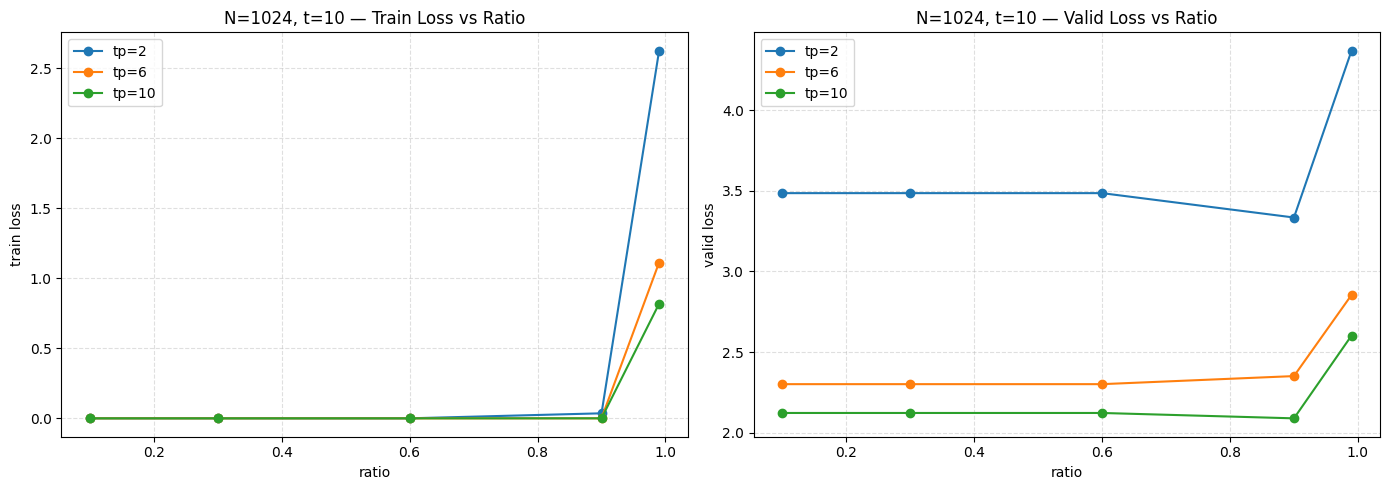

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# ===========================================================
# 1. 解析单个日志文件（只取最后一个值）
# ===========================================================

re_train = re.compile(r"train loss:\s*([\d\.Ee+\-]+)")
re_valid = re.compile(r"valid loss:\s*([\d\.Ee+\-]+)")

def parse_log_last(path):
    train_vals = []
    valid_vals = []

    with open(path, "r") as f:
        for line in f:
            m = re_train.search(line)
            if m:
                train_vals.append(float(m.group(1)))

            m = re_valid.search(line)
            if m:
                valid_vals.append(float(m.group(1)))

    return {
        "train_loss": train_vals[-1] if train_vals else None,
        "valid_loss": valid_vals[-1] if valid_vals else None
    }


# ===========================================================
# 2. 从文件名解析参数
# ===========================================================

def parse_filename(fname):
    m = re.search(r"N(\d+)_tp(\d+)_temp(\d+)_ratio([0-9.]+).log", fname)
    if not m:
        return None
    return {
        "N": int(m.group(1)),
        "tp": int(m.group(2)),
        "t": int(m.group(3)),
        "ratio": float(m.group(4)),
    }


# ===========================================================
# 3. 读取全部日志
# ===========================================================

def load_all_logs(log_dir):
    results = {}  # results[N][tp][t][ratio]

    for fname in os.listdir(log_dir):
        if not fname.endswith(".log"):
            continue

        params = parse_filename(fname)
        if params is None:
            continue

        path = os.path.join(log_dir, fname)
        stat = parse_log_last(path)

        N = params["N"]
        tp = params["tp"]
        t = params["t"]
        ratio = params["ratio"]

        results.setdefault(N, {})
        results[N].setdefault(tp, {})
        results[N][tp].setdefault(t, {})
        results[N][tp][t][ratio] = stat

    return results


# ===========================================================
# 4. 绘图（matplotlib）
# ===========================================================

def plot_loss_vs_ratio(results, N, t_filter):
    """
    results[N][tp][t][ratio] -> {train_loss, valid_loss}
    仅绘制指定 temperature (t_filter)
    不同曲线代表不同 tp
    """

    if N not in results:
        raise ValueError(f"No data for N={N}")

    # 所有 tp
    tp_list = sorted(results[N].keys())

    # 准备 figure
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax_train, ax_valid = ax

    cmap = plt.get_cmap("tab10")

    for i, tp in enumerate(tp_list):
        if t_filter not in results[N][tp]:
            continue

        # ratio -> 数据
        items = sorted(results[N][tp][t_filter].items(), key=lambda x: x[0])
        ratios = [r for r, _ in items]
        train_vals = [d["train_loss"] for _, d in items]
        valid_vals = [d["valid_loss"] for _, d in items]

        color = cmap(i % 10)

        ax_train.plot(ratios, train_vals, marker="o", color=color, label=f"tp={tp}")
        ax_valid.plot(ratios, valid_vals, marker="o", color=color, label=f"tp={tp}")

    ax_train.set_title(f"N={N}, t={t_filter} — Train Loss vs Ratio")
    ax_valid.set_title(f"N={N}, t={t_filter} — Valid Loss vs Ratio")

    ax_train.set_xlabel("ratio")
    ax_valid.set_xlabel("ratio")
    ax_train.set_ylabel("train loss")
    ax_valid.set_ylabel("valid loss")

    ax_train.grid(True, linestyle="--", alpha=0.4)
    ax_valid.grid(True, linestyle="--", alpha=0.4)

    ax_train.legend()
    ax_valid.legend()

    plt.tight_layout()
    plt.show()


# ===========================================================
# 5. 使用示例
# ===========================================================

if __name__ == "__main__":
    log_dir = "."
    results = load_all_logs(log_dir)

    # 选择 N = 1024, t = 6 (示例)
    plot_loss_vs_ratio(results, N=1024, t_filter=10)


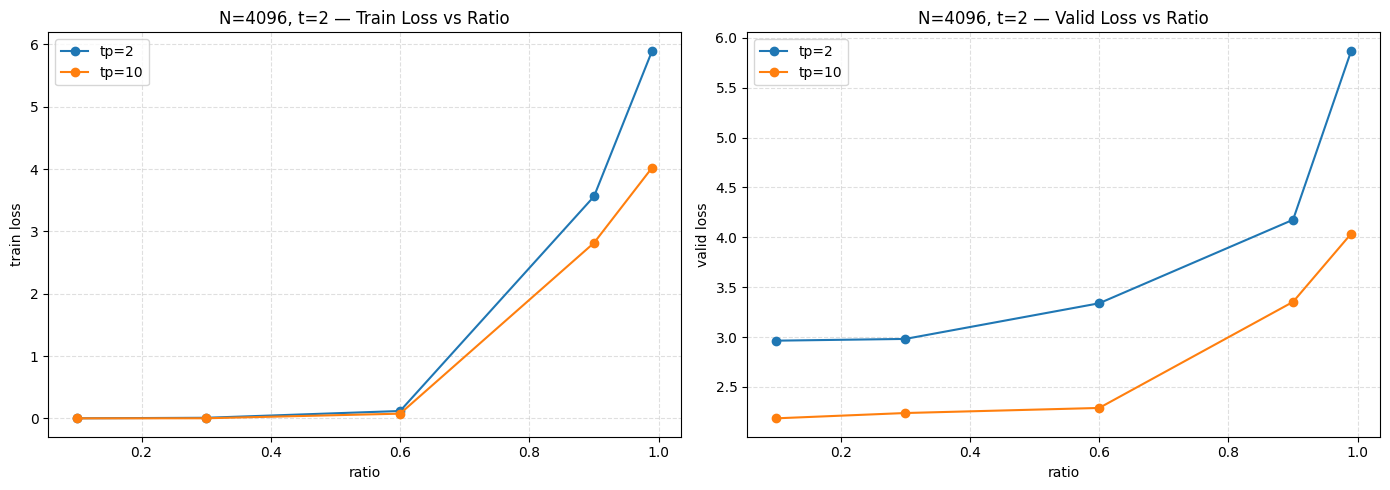

In [28]:
log_dir = "."
results = load_all_logs(log_dir)
plot_loss_vs_ratio(results, N=4096, t_filter=2)


In [10]:
import plotly.io as pio
print("Default renderer:", pio.renderers.default)
print("Available renderers:", pio.renderers)


Default renderer: iframe
Available renderers: Renderers configuration
-----------------------
    Default renderer: 'iframe'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

